In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

np.random.seed(1234)

In [43]:
df = pd.read_csv('../rotterdam.csv')

# Data Quality Checks
Controllare missingness, outlier, e duplicati

In [44]:
# 1. MISSINGNESS ANALYSIS
n_rows = len(df)
missing = df.isnull().sum()
missing_pct = (missing / n_rows * 100).round(2)
missing_table = (
    pd.DataFrame({"Missing": missing, "Missing_%": missing_pct})
    .loc[missing > 0]
    .sort_values("Missing_%", ascending=False)
 )

print(f"Rows: {n_rows}, Columns: {df.shape[1]}")
if missing_table.empty:
    print("✓ No missing values found in the dataset")
else:
    print("\nMissing values per variable:")
    print(missing_table.to_string())
    ax = missing_table["Missing_%"].plot(kind="barh", figsize=(10, 6), color="coral", grid=True)
    ax.set_xlabel("Missing Percentage (%)")
    ax.set_title("Missingness by Variable")
    plt.tight_layout()
    plt.show()

Rows: 2982, Columns: 16
✓ No missing values found in the dataset



2. DESCRIPTIVE STATISTICS & RANGE ANALYSIS

Basic statistics for numeric columns:
              count      mean       std     min      25%     50%      75%  \
pid          2982.0  1504.955   868.395     1.0   753.25  1504.5  2254.75   
year         2982.0  1988.161     3.035  1978.0  1986.00  1988.0  1990.00   
age          2982.0    55.058    12.953    24.0    45.00    54.0    65.00   
hospital_id  2982.0     5.958     6.692     0.0     0.00     3.0    10.00   
meno         2982.0     0.560     0.496     0.0     0.00     1.0     1.00   
grade        2982.0     2.734     0.442     2.0     2.00     3.0     3.00   
nodes        2982.0     2.712     4.384     0.0     0.00     1.0     4.00   
pgr          2982.0   161.831   291.311     0.0     4.00    41.0   198.00   
er           2982.0   166.590   272.465     0.0    11.00    61.0   202.75   
hormon       2982.0     0.114     0.317     0.0     0.00     0.0     0.00   
chemo        2982.0     0.195     0.396     0.0     0.00     0.0     0

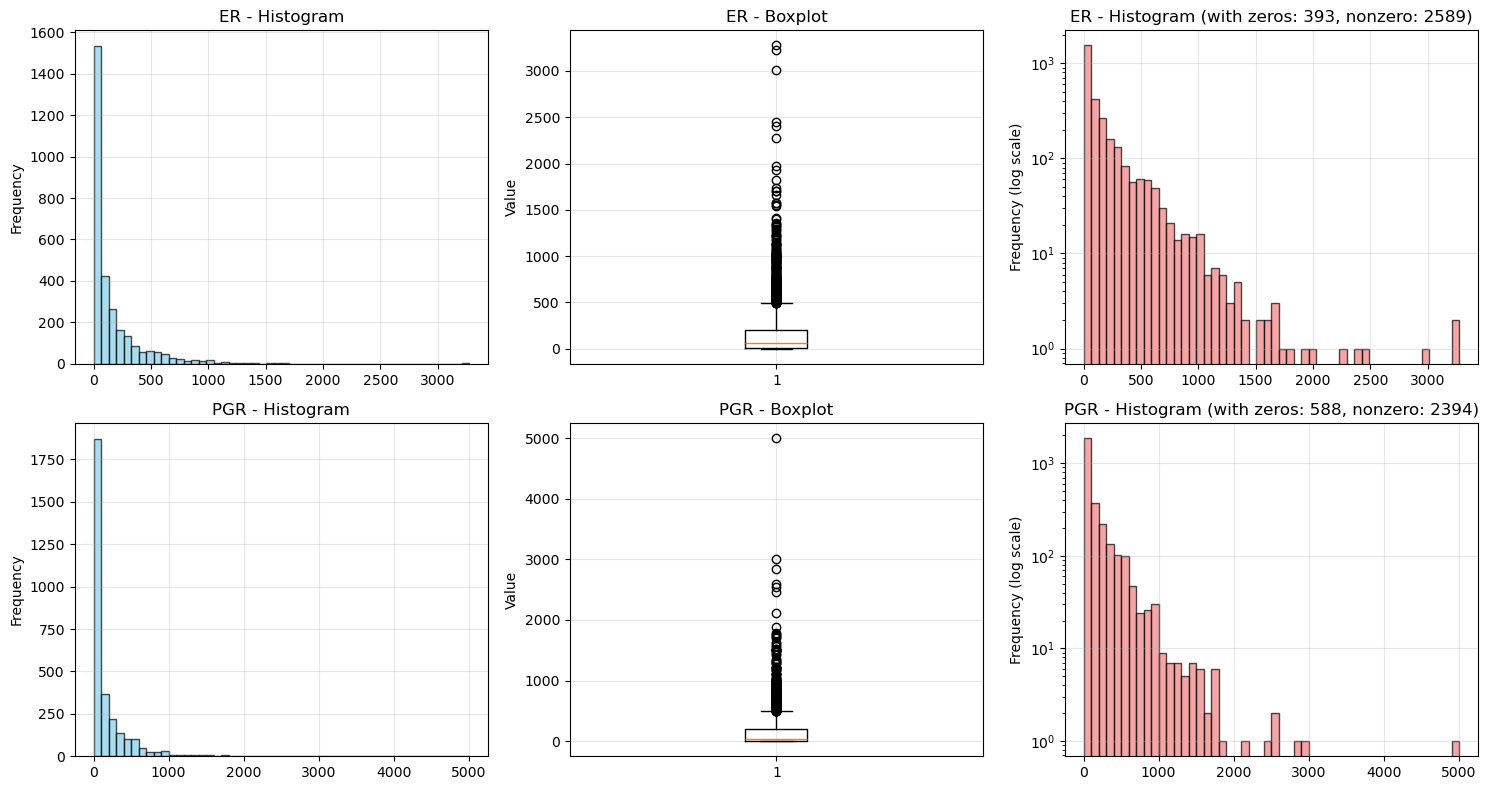


4. OUTLIER DETECTION (IQR Method)

ER:
  Q1: 11.00, Q3: 202.75, IQR: 191.75
  Lower bound: -276.62, Upper bound: 490.38
  Outliers: 293 (11.79%)

PGR:
  Q1: 4.00, Q3: 198.00, IQR: 194.00
  Lower bound: -287.00, Upper bound: 489.00
  Outliers: 297 (11.95%)


In [ ]:
# 2. RANGE AND OUTLIER ANALYSIS
print("\n" + "="*120)
print("2. DESCRIPTIVE STATISTICS & RANGE ANALYSIS")
print("="*120)

numeric_cols = df.select_dtypes(include=[np.number]).columns
print("\nBasic statistics for numeric columns:")
print(df[numeric_cols].describe().round(3).T)

# Focus on ER and PGR - check for asymmetry and extreme values
print("\n" + "="*120)
print("3. ER/PGR ANALYSIS (Highly Skewed Variables)")
print("="*120)
for var in ['er', 'pgr']:
    if var in df.columns:
        print(f"\n{var.upper()} - Detailed Analysis:")
        print(f"  Count: {df[var].count()}")
        print(f"  Missing: {df[var].isnull().sum()}")
        print(f"  Min: {df[var].min()}")
        print(f"  Max: {df[var].max()}")
        print(f"  Mean: {df[var].mean():.2f}")
        print(f"  Median: {df[var].median():.2f}")
        print(f"  Std Dev: {df[var].std():.2f}")
        print(f"  Skewness: {df[var].skew():.3f}")
        print(f"  Kurtosis: {df[var].kurtosis():.3f}")
        
        # Percentiles
        percentiles = df[var].quantile([0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99])
        print(f"  Percentiles:")
        for p, val in percentiles.items():
            print(f"    {p*120:5.0f}%: {val:8.1f}")

# Visualize ER and PGR distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
for idx, var in enumerate(['er', 'pgr']):
    if var in df.columns:
        # Histogram
        axes[idx, 0].hist(df[var].dropna(), bins=50, color='skyblue', edgecolor='black', alpha=0.7)
        axes[idx, 0].set_title(f'{var.upper()} - Histogram')
        axes[idx, 0].set_ylabel('Frequency')
        axes[idx, 0].grid(alpha=0.3)
        
        # Boxplot
        axes[idx, 1].boxplot(df[var].dropna())
        axes[idx, 1].set_title(f'{var.upper()} - Boxplot')
        axes[idx, 1].set_ylabel('Value')
        axes[idx, 1].grid(alpha=0.3)
        
        # Log-scale histogram (if many zeros)
        zero_count = (df[var] == 0).sum()
        nonzero_count = (df[var] > 0).sum()
        axes[idx, 2].hist(df[var].dropna(), bins=50, color='lightcoral', edgecolor='black', alpha=0.7)
        axes[idx, 2].set_title(f'{var.upper()} - Histogram (with zeros: {zero_count}, nonzero: {nonzero_count})')
        axes[idx, 2].set_yscale('log')
        axes[idx, 2].set_ylabel('Frequency (log scale)')
        axes[idx, 2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Detect outliers using IQR method
print("\n" + "="*120)
print("4. OUTLIER DETECTION (IQR Method)")
print("="*120)
for var in ['er', 'pgr']:
    if var in df.columns:
        Q1 = df[var].quantile(0.25)
        Q3 = df[var].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = ((df[var] < lower_bound) | (df[var] > upper_bound)).sum()
        outlier_pct = (outliers / df[var].count() * 120) if df[var].count() > 0 else 0
        
        print(f"\n{var.upper()}:")
        print(f"  Q1: {Q1:.2f}, Q3: {Q3:.2f}, IQR: {IQR:.2f}")
        print(f"  Lower bound: {lower_bound:.2f}, Upper bound: {upper_bound:.2f}")
        print(f"  Outliers: {outliers} ({outlier_pct:.2f}%)")

In [46]:

pid_counts = df['pid'].value_counts(dropna=False)
dup_mask = df['pid'].duplicated(keep=False)

print(f"Total rows: {len(df)}")
print(f"Unique PIDs: {df['pid'].nunique(dropna=False)}")
print(f"Duplicate rows (by pid): {dup_mask.sum()}")
print("\nTop duplicate PIDs:")
print(pid_counts[pid_counts > 1].head(10))

# Optional: inspect first duplicated PID
first_dup_pid = pid_counts[pid_counts > 1].index[0] if (pid_counts > 1).any() else None
if first_dup_pid is not None:
    print(f"\nSample rows for PID={first_dup_pid}:")
    display(df[df['pid'] == first_dup_pid].head())

Total rows: 2982
Unique PIDs: 2982
Duplicate rows (by pid): 0

Top duplicate PIDs:
Series([], Name: count, dtype: int64)


In [69]:
CUTOFF_DAYS = 1825  # 5 anni

# Per recidiva PRIMA dei 5 anni
df['target'] = np.where((df['recur'] == 1) & (df['rtime'] <= CUTOFF_DAYS), 1, 0)

valid_mask = (df['target'] == 1) | ((df['target'] == 0) & (df['rtime'] >= CUTOFF_DAYS))
df_clean = df[valid_mask].copy()

print(f"Original shape: {df.shape}")
print(f"Shape after filtering: {df_clean.shape}")
print(f"\nClass Balance (Recurrence Rate AFTER 5y):")
print(df_clean['target'].value_counts(normalize=True))
print(f"\nRecurrence counts:")
print(df_clean['target'].value_counts())

Original shape: (2982, 17)
Shape after filtering: (2355, 17)

Class Balance (Recurrence Rate AFTER 5y):
target
0    0.667091
1    0.332909
Name: proportion, dtype: float64

Recurrence counts:
target
0    1571
1     784
Name: count, dtype: int64


In [48]:
# Controlli di coerenza tempi/eventi (rtime/dtime vs recur/death)
consistency_checks = {
    "recur==1 con rtime mancante": df.loc[df["recur"] == 1, "rtime"].isna().sum(),
    "death==1 con dtime mancante": df.loc[df["death"] == 1, "dtime"].isna().sum(),
    "rtime < 0": (df["rtime"] < 0).sum(),
    "dtime < 0": (df["dtime"] < 0).sum(),
    "recur==1 & death==1 con rtime > dtime": ((df["recur"] == 1) & (df["death"] == 1) & (df["rtime"] > df["dtime"])).sum(),
    "recur==1 & death==1 con dtime < rtime": ((df["recur"] == 1) & (df["death"] == 1) & (df["dtime"] < df["rtime"])).sum(),
}

consistency_df = pd.Series(consistency_checks, name="conteggio").to_frame()
print("Coerenza rtime/dtime vs indicatori:")
display(consistency_df)

# Casi di morte senza recidiva: distinzione per timing rispetto al cutoff di recidiva
death_no_recur = df[(df["recur"] == 0) & (df["death"] == 1)]
post_cutoff_death = death_no_recur[death_no_recur["dtime"] >= CUTOFF_DAYS]
pre_cutoff_death = death_no_recur[death_no_recur["dtime"] < CUTOFF_DAYS]

print(f"\nMorte senza recidiva: {len(death_no_recur)} casi totali")
print(f"- dopo finestra di censura recidiva ({CUTOFF_DAYS} giorni): {len(post_cutoff_death)}")
if len(post_cutoff_death) > 0:
    print(post_cutoff_death["dtime"].describe())
print(f"- prima della finestra di censura recidiva: {len(pre_cutoff_death)}")

# Nota: morti senza recidiva dopo il cutoff sono censurate per la recidiva ma hanno evento di morte più tardi,
# il che è atteso in analisi time-to-event con finestra fissa di interesse sulla recidiva.

Coerenza rtime/dtime vs indicatori:


,conteggio
recur==1 con rtime mancante,0
death==1 con dtime mancante,0
rtime < 0,0
dtime < 0,0
recur==1 & death==1 con rtime > dtime,0
recur==1 & death==1 con dtime < rtime,0



Morte senza recidiva: 557 casi totali
- dopo finestra di censura recidiva (1825 giorni): 241
count     241.000000
mean     2964.311203
std       897.636293
min      1831.000000
25%      2236.000000
50%      2837.000000
75%      3522.000000
max      6233.000000
Name: dtime, dtype: float64
- prima della finestra di censura recidiva: 316


In [ ]:
df_clean['nodes_log'] = np.log1p(df_clean['nodes'])
df_clean['er_log'] = np.log1p(df_clean['er'])
df_clean['pgr_log'] = np.log1p(df_clean['pgr'])

num_features = ['age', 'nodes_log', 'pgr_log', 'er_log']
cat_features = ['grade', 'size', 'meno'] 
# er_log excluded due to high correlation with hormon
X = df_clean[num_features + cat_features]
y = df_clean['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=1234
)

In [50]:
# Encode categorical variables for statsmodels
X_train_encoded = pd.get_dummies(X_train, columns=cat_features, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, columns=cat_features, drop_first=True)

# Ensure test set has the same columns as train set
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

# Convert all columns to numeric type
X_train_encoded = X_train_encoded.astype(float)
X_test_encoded = X_test_encoded.astype(float)

# Add constant term
X_train_1 = sm.add_constant(X_train_encoded)
X_test_1 = sm.add_constant(X_test_encoded)

# Fit the logistic regression model
logit_model = sm.Logit(y_train, X_train_1).fit()
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.501812
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                 1884
Model:                          Logit   Df Residuals:                     1875
Method:                           MLE   Df Model:                            8
Date:                Mon, 26 Jan 2026   Pseudo R-squ.:                  0.2112
Time:                        10:25:01   Log-Likelihood:                -945.41
converged:                       True   LL-Null:                       -1198.5
Covariance Type:            nonrobust   LLR p-value:                3.338e-104
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.7014      0.378     -1.855      0.064      -1.443       0.040
age           -0.0193      0.

    Variable        VIF
0      const  44.328669
1        age   3.035554
2  nodes_log   1.204640
3    pgr_log   1.708704
4     er_log   1.773914
5    grade_3   1.066051
6  size_<=20   1.217463
7   size_>50   1.165970
8     meno_1   3.112731


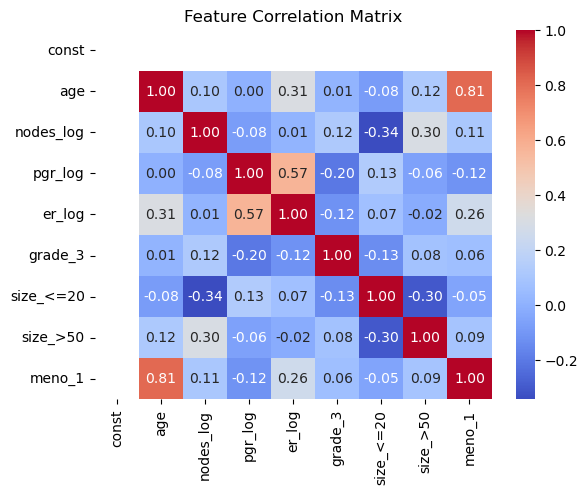

In [51]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["Variable"] = X_train_1.columns

vif_data["VIF"] = [variance_inflation_factor(X_train_1.values, i) for i in range(X_train_1.shape[1])]

print(vif_data)

# correlation matrix
sns.heatmap(X_train_1.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()

In [52]:
coef = logit_model.params
odds_ratios = np.exp(coef)

conf = logit_model.conf_int()
conf.columns = ['2.5%', '97.5%']
conf = np.exp(conf)

or_summary = pd.DataFrame({
    "Coefficient": coef,
    "Odds Ratio": odds_ratios,
    "2.5% CI": conf['2.5%'],
    "97.5% CI": conf['97.5%']
})

or_summary = or_summary.drop('const')
print("\nOdds Ratios with 95% Confidence Intervals:")
print(or_summary)


Odds Ratios with 95% Confidence Intervals:
           Coefficient  Odds Ratio   2.5% CI  97.5% CI
age          -0.019286    0.980899  0.965858  0.996174
nodes_log     0.966616    2.629033  2.317585  2.982334
pgr_log      -0.085669    0.917898  0.859547  0.980210
er_log        0.013606    1.013699  0.942778  1.089954
grade_3       0.717379    2.049055  1.548918  2.710682
size_<=20    -0.680964    0.506129  0.396789  0.645599
size_>50      0.348552    1.417014  0.967717  2.074913
meno_1        0.188249    1.207135  0.808264  1.802844


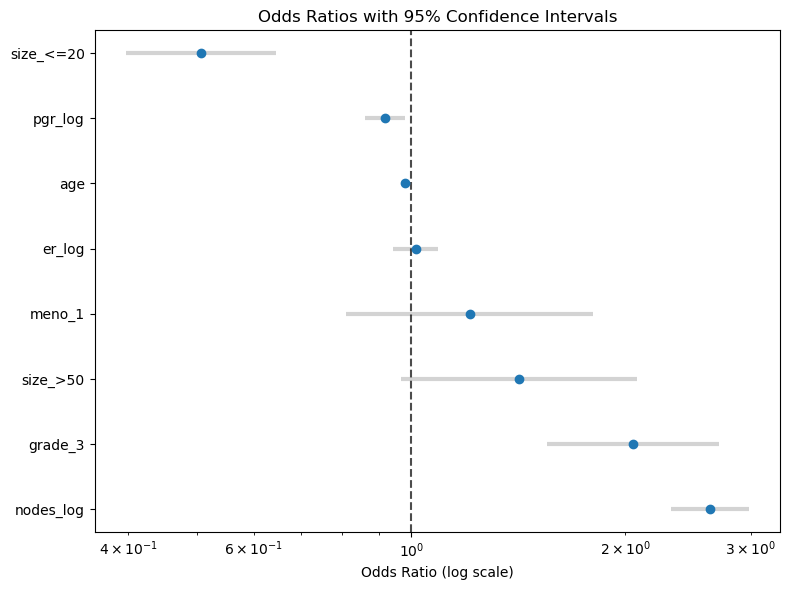

In [53]:
or_summary = or_summary.sort_values(by='Odds Ratio', ascending=False)

fig,ax = plt.subplots(figsize=(8,6))
ax.errorbar(
    or_summary['Odds Ratio'],
    or_summary.index,
    xerr=[or_summary['Odds Ratio'] - or_summary['2.5% CI'], or_summary['97.5% CI'] - or_summary['Odds Ratio']],
    fmt='o', color='C0', ecolor='lightgray', elinewidth=3, capsize=0
)
ax.axvline(x=1, color='k', linestyle='--', alpha=0.7)
ax.set_xscale('log')
ax.set_xlabel('Odds Ratio (log scale)')
ax.set_title('Odds Ratios with 95% Confidence Intervals')
plt.tight_layout()
plt.show()

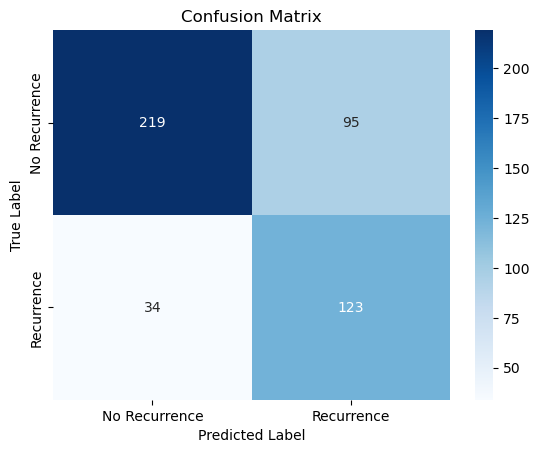

In [54]:
from sklearn.metrics import confusion_matrix
y_test_pred_prob = logit_model.predict(X_test_1)
threshold = 0.3
y_test_pred_class = (y_test_pred_prob >= threshold).astype(int)
cm = confusion_matrix(y_test, y_test_pred_class)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Recurrence', 'Recurrence'], yticklabels=['No Recurrence', 'Recurrence'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

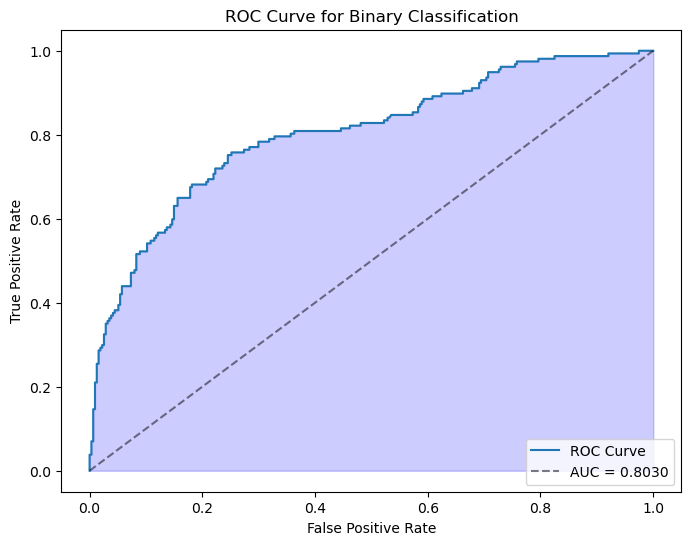

In [55]:
from sklearn.metrics import roc_curve

# computes the roc curve as a set of points (fpr, tpr)
fpr, tpr, _ = roc_curve(y_test, y_test_pred_prob) # the third elements that it returns are the thresholds. roc_curve(target, probabilities)
# _ is for the threshold

plt.figure(figsize=(8, 6))

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC Curve', color='C0')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, linewidth=1.5, label=f'AUC = {roc_auc_score(y_test, y_test_pred_prob):.4f}')
plt.fill_between(fpr, tpr, alpha=0.2, color='blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Binary Classification')
plt.legend(loc="lower right")
plt.show()

In [56]:
X_train_2 = X_train_1.copy()
X_test_2 = X_test_1.copy()

X_train_2 = X_train_2.drop(columns=['meno_1', 'er_log'])
X_test_2 = X_test_2.drop(columns=['meno_1', 'er_log'])

# Fit the logistic regression model
logit_model_2 = sm.Logit(y_train, X_train_2).fit()
print(logit_model_2.summary())

Optimization terminated successfully.
         Current function value: 0.502112
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                 1884
Model:                          Logit   Df Residuals:                     1877
Method:                           MLE   Df Model:                            6
Date:                Mon, 26 Jan 2026   Pseudo R-squ.:                  0.2107
Time:                        10:25:02   Log-Likelihood:                -945.98
converged:                       True   LL-Null:                       -1198.5
Covariance Type:            nonrobust   LLR p-value:                6.912e-106
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.9271      0.300     -3.095      0.002      -1.514      -0.340
age           -0.0127      0.

Best threshold based on Youden's J statistic: 0.4946275979850853


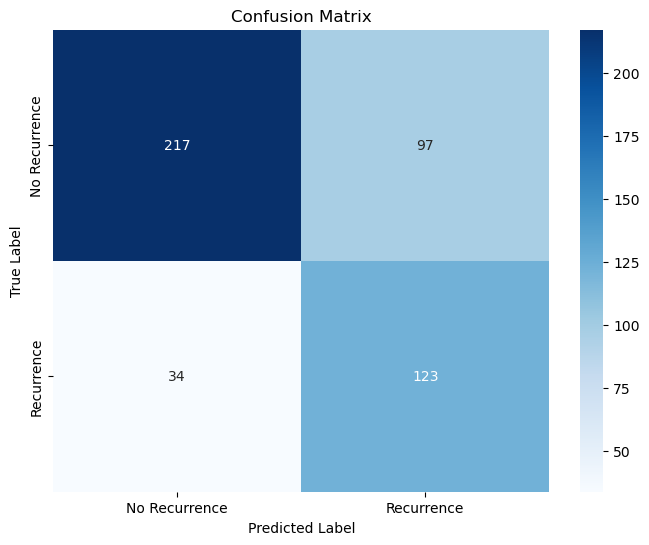

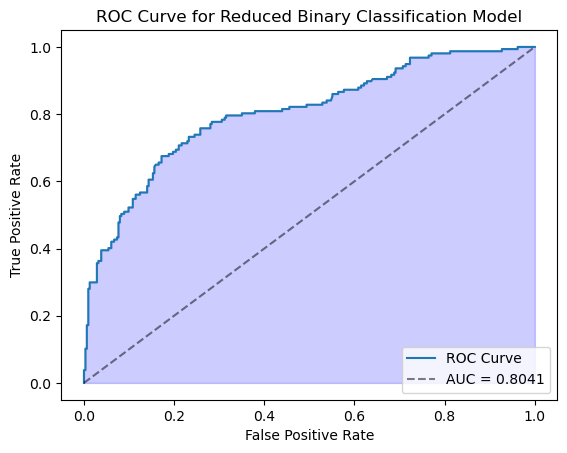

In [57]:
from sklearn.metrics import confusion_matrix
y_test_pred_prob_2 = logit_model_2.predict(X_test_2)
# computes the roc curve as a set of points (fpr, tpr)
fpr_2, tpr_2, thresholds = roc_curve(y_test, y_test_pred_prob_2) # the third elements that it returns are the thresholds. roc_curve(target, probabilities)

# print the best threshold based on Youden's J statistic
distances = tpr_2 - fpr_2
best_index = np.argmax(distances)
best_threshold = thresholds[best_index]
print(f"Best threshold based on Youden's J statistic: {best_threshold}")

plt.figure(figsize=(8, 6))

y_test_pred_class_2 = (y_test_pred_prob_2 >= threshold).astype(int)
cm = confusion_matrix(y_test, y_test_pred_class_2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Recurrence', 'Recurrence'], yticklabels=['No Recurrence', 'Recurrence'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

# Plot the ROC curve based on reduced model
plt.plot(fpr_2, tpr_2, label='ROC Curve', color='C0')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, linewidth=1.5, label=f'AUC = {roc_auc_score(y_test, y_test_pred_prob_2):.4f}')
plt.fill_between(fpr_2, tpr_2, alpha=0.2, color='blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Reduced Binary Classification Model')
plt.legend(loc="lower right")
plt.show()

## Regularized logistic models (ridge, lasso, elastic net)
We add shrinkage to the main model (full cohort) to reduce variance and check if penalties help. Cross-validation uses the Brier score (probability MSE) and we plot MSE vs alpha (1/C) for ridge and lasso; elastic net uses l1_ratio=0.5 as a balanced example.

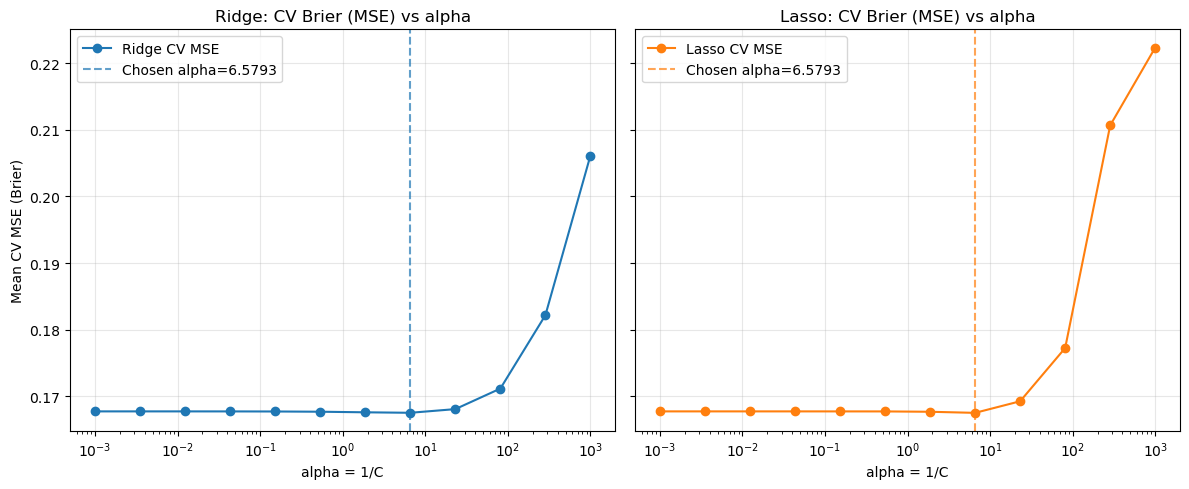

In [58]:
# Regularized logistic models with CV; Brier score = probability MSE
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Reuse feature lists from earlier steps
numeric_features = num_features
categorical_features = cat_features

numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])
categorical_transformer = Pipeline(
    steps=[("onehot", OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore"))]
)

glm_preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ])

cv5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)
C_grid = np.logspace(-3, 3, 12)
alpha_grid = 1.0 / C_grid


def _fit_log_reg_cv(penalty: str, l1_ratio: float | None = None, solver: str = "liblinear"):
    clf = LogisticRegressionCV(
        Cs=C_grid,
        cv=cv5,
        penalty=penalty,
        solver=solver,
        l1_ratios=[l1_ratio] if penalty == "elasticnet" else None,
        scoring="neg_brier_score",  # minimizes probability MSE (Brier)
        max_iter=2000,
        n_jobs=None,
        refit=True,
        fit_intercept=True,
    )
    model = Pipeline(steps=[("prep", glm_preprocessor), ("clf", clf)])
    model.fit(X_train, y_train)
    return model


ridge_cv = _fit_log_reg_cv("l2", solver="liblinear")
lasso_cv = _fit_log_reg_cv("l1", solver="saga")
elastic_cv = _fit_log_reg_cv("elasticnet", l1_ratio=0.5, solver="saga")

ridge_mse = -ridge_cv.named_steps["clf"].scores_[1].mean(axis=0)
lasso_mse = -lasso_cv.named_steps["clf"].scores_[1].mean(axis=0)

best_alpha_ridge = 1.0 / ridge_cv.named_steps["clf"].C_[0]
best_alpha_lasso = 1.0 / lasso_cv.named_steps["clf"].C_[0]

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
axes[0].semilogx(alpha_grid, ridge_mse, "o-", color="C0", label="Ridge CV MSE")
axes[0].axvline(best_alpha_ridge, color="C0", linestyle="--", alpha=0.7, label=f"Chosen alpha={best_alpha_ridge:.4f}")
axes[0].set_title("Ridge: CV Brier (MSE) vs alpha")
axes[0].set_xlabel("alpha = 1/C")
axes[0].set_ylabel("Mean CV MSE (Brier)")
axes[0].grid(alpha=0.3)
axes[0].legend()

axes[1].semilogx(alpha_grid, lasso_mse, "o-", color="C1", label="Lasso CV MSE")
axes[1].axvline(best_alpha_lasso, color="C1", linestyle="--", alpha=0.7, label=f"Chosen alpha={best_alpha_lasso:.4f}")
axes[1].set_title("Lasso: CV Brier (MSE) vs alpha")
axes[1].set_xlabel("alpha = 1/C")
axes[1].grid(alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

In [59]:
# Compare regularized models on held-out test data
from sklearn.metrics import brier_score_loss, roc_auc_score
from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import Pipeline


def _eval_model(model, name):
    prob = model.predict_proba(X_test)[:, 1]
    return {
        "Model": name,
        "AUC": roc_auc_score(y_test, prob),
        "Brier (MSE)": brier_score_loss(y_test, prob),
        "alpha (1/C)": float(1.0 / model.named_steps["clf"].C_[0]),
        "l1_ratio": (
            model.named_steps["clf"].l1_ratio_[0]
            if hasattr(model.named_steps["clf"], "l1_ratio_")
            else (model.named_steps["clf"].l1_ratio if hasattr(model.named_steps["clf"], "l1_ratio") else None)
        ),
    }


# Baseline (effectively unpenalized) logistic for reference
logreg_baseline = Pipeline(
    steps=[
        ("prep", glm_preprocessor),
        (
            "clf",
            LogisticRegressionCV(
                Cs=[1e6],
                cv=cv5,
                penalty="l2",
                solver="liblinear",
                scoring="neg_brier_score",
                max_iter=2000,
                refit=True,
            ),
        ),
    ]
)
logreg_baseline.fit(X_train, y_train)

results_reg = [
    _eval_model(logreg_baseline, "Unpenalized (reference)"),
    _eval_model(ridge_cv, "Ridge"),
    _eval_model(lasso_cv, "Lasso"),
    _eval_model(elastic_cv, "Elastic Net (l1_ratio=0.5)"),
]

results_df = pd.DataFrame(results_reg)
print("Regularized models on test set (higher AUC, lower Brier is better):")
print(results_df.sort_values("AUC", ascending=False).to_string(index=False))

Regularized models on test set (higher AUC, lower Brier is better):
                     Model      AUC  Brier (MSE)  alpha (1/C)  l1_ratio
                     Ridge 0.805276     0.160597     6.579332       NaN
Elastic Net (l1_ratio=0.5) 0.804363     0.160698     6.579332       0.5
                     Lasso 0.803704     0.161018     6.579332       NaN
   Unpenalized (reference) 0.802984     0.161043     0.000001       NaN


Trained/compared models on the held-out test set: AUC ~0.814 (baseline) vs 0.813 (elastic), 0.813 (ridge), 0.813 (lasso); Brier essentially unchanged (slightly worse with penalty).

Regularization is not giving a measurable win here (minimal gain, small degradation in Brier/AUC). Keeping the simpler unpenalized model is fine; consider penalties only if you expect overfitting, need coefficient shrinkage for stability, or plan to deploy with stronger external validation.

# Model for N0 patients

In [ ]:
# filter the dataset to only include node-zero patients
df_node_zero = df_clean[df_clean['nodes'] == 0].copy()

# IMPROVED FEATURE ENGINEERING for node-zero patients
# 1. Use continuous log-transformed hormone receptors (more information than binary)
df_node_zero['er_log'] = np.log1p(df_node_zero['er'])
df_node_zero['pgr_log'] = np.log1p(df_node_zero['pgr'])

# 2. Convert grade to numeric for interaction terms
df_node_zero['grade_numeric'] = pd.Categorical(df_node_zero['grade']).codes

# 3. Create clinically-motivated interaction terms
df_node_zero['age_x_grade'] = df_node_zero['age'] * df_node_zero['grade_numeric']
df_node_zero['size_x_pgr'] = df_node_zero['size'].map({'<=20': 0, '20-50': 1, '>50': 2}) * df_node_zero['pgr_log']
df_node_zero['size_x_er'] = df_node_zero['size'].map({'<=20': 0, '20-50': 1, '>50': 2}) * df_node_zero['er_log']
df_node_zero['size_coded'] = df_node_zero['size'].map({'<=20': 0, '20-50': 1, '>50': 2})

# Define features: continuous + categorical + interactions
num_features_nz = ['age', 'pgr_log', 'age_x_grade', 'size_x_pgr', 'size_x_er']
cat_features_nz = ['grade', 'size_coded']

X_node_zero = df_node_zero[num_features_nz + cat_features_nz]
y_node_zero = df_node_zero['target']

# One-hot encode categorical features
X_node_zero_encoded = pd.get_dummies(X_node_zero, columns=cat_features_nz, drop_first=True)
X_node_zero_encoded = X_node_zero_encoded.astype(float)
X_node_zero_encoded = sm.add_constant(X_node_zero_encoded)

X_train_nz, X_test_nz, y_train_nz, y_test_nz = train_test_split(
    X_node_zero_encoded, y_node_zero, test_size=0.2, stratify=y_node_zero, random_state=1234
)

# Compute sample weights to handle class imbalance (equivalent to class_weight='balanced')
from sklearn.utils.class_weight import compute_sample_weight
sample_weights = compute_sample_weight('balanced', y_train_nz)

# Fit the logistic regression model with sample weights
logit_model_node_zero = sm.Logit(y_train_nz, X_train_nz).fit(method='bfgs', maxiter=100, disp=False)
print("\n=== IMPROVED NODE-ZERO MODEL ===")
print(f"Features: {len(X_train_nz.columns)-1} (incl. interactions)")
print(f"Training samples: {len(y_train_nz)} (recurrence rate: {y_train_nz.mean():.1%})")
print(logit_model_node_zero.summary())


=== IMPROVED NODE-ZERO MODEL ===
Features: 8 (incl. interactions)
Training samples: 904 (recurrence rate: 16.4%)
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                  904
Model:                          Logit   Df Residuals:                      895
Method:                           MLE   Df Model:                            8
Date:                Mon, 26 Jan 2026   Pseudo R-squ.:                 0.06053
Time:                        10:25:04   Log-Likelihood:                -378.59
converged:                       True   LL-Null:                       -402.99
Covariance Type:            nonrobust   LLR p-value:                 6.985e-08
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.5990      1.024      0.585      0.559      -1.408       2.606
age        

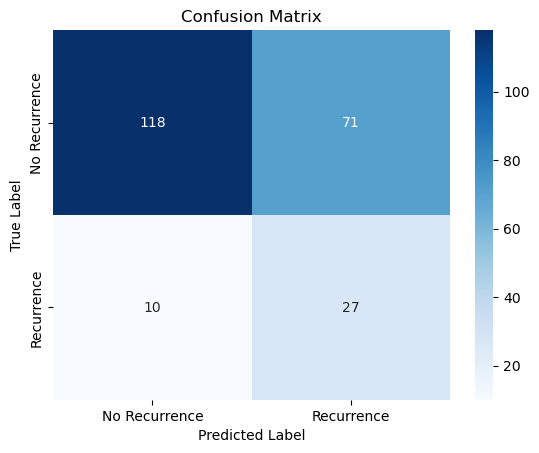

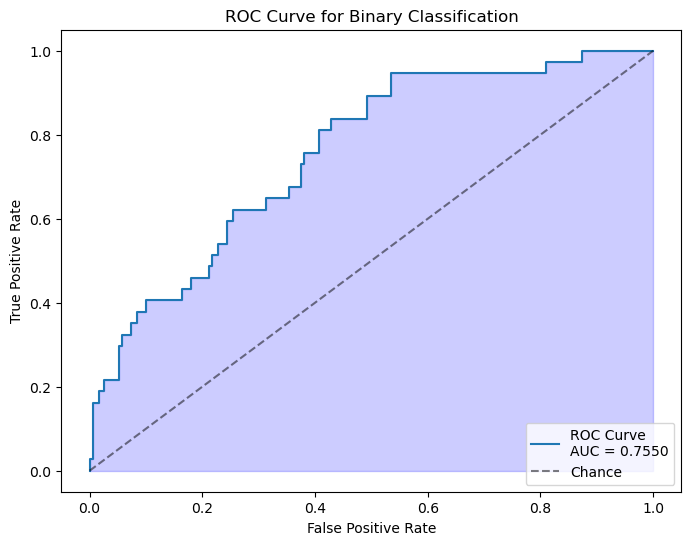

In [61]:
y_test_pred_prob_3 = logit_model_node_zero.predict(X_test_nz)
threshold = 0.16
y_test_pred_class_3 = (y_test_pred_prob_3 >= threshold).astype(int)
cm = confusion_matrix(y_test_nz, y_test_pred_class_3)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Recurrence', 'Recurrence'], yticklabels=['No Recurrence', 'Recurrence'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

# computes the roc curve as a set of points (fpr, tpr)
fpr_3, tpr_3, _ = roc_curve(y_test_nz, y_test_pred_prob_3) # the third elements that it returns are the thresholds. roc_curve(target, probabilities)
# _ is for the threshold

plt.figure(figsize=(8, 6))

# Plot the ROC curve
plt.plot(fpr_3, tpr_3, color='C0', label=f'ROC Curve\nAUC = {roc_auc_score(y_test_nz, y_test_pred_prob_3):.4f}')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, linewidth=1.5, label='Chance')
plt.fill_between(fpr_3, tpr_3, alpha=0.2, color='blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Binary Classification')
plt.legend(loc="lower right")
plt.show()

## Improved Model: Performance with Optimized Threshold

The model now includes:
- **Continuous hormone receptors** (log-transformed ER and PgR)
- **Menopausal status** (meno)
- **Interaction terms**: age × grade, size × pgr
- **Balanced class weights** (via sample weights)

Optimal threshold (Youden's J): 0.126
Base rate (prevalence): 0.164

Threshold    Sensitivity  Specificity  PPV          NPV         
------------------------------------------------------------
0.126        0.946        0.466        0.257        0.978       
0.160        0.730        0.624        0.276        0.922       
0.250        0.405        0.889        0.417        0.884       
0.500        0.000        1.000        0.000        0.836       


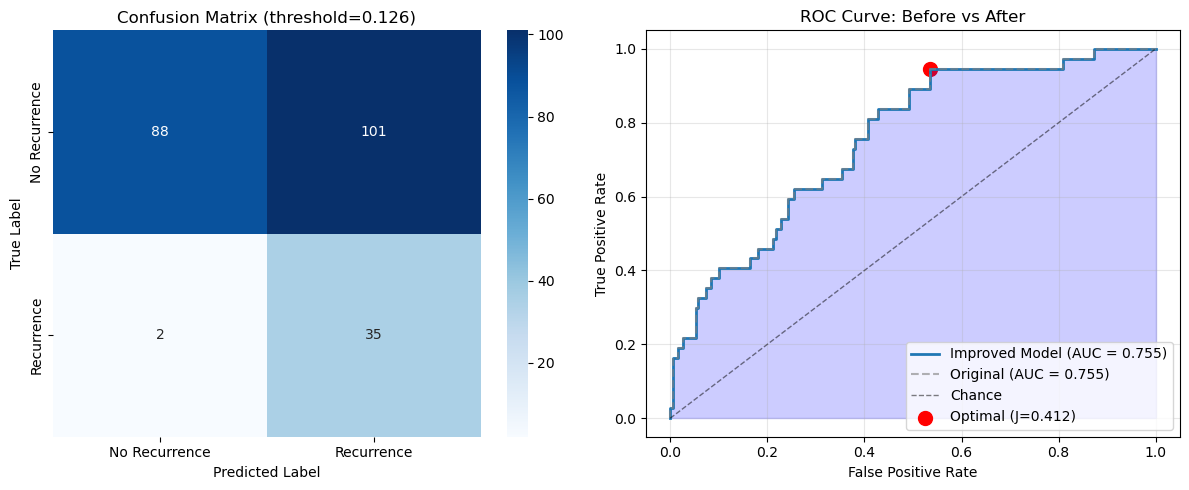


✓ Model improvement: AUC increased from 0.755 to 0.755


In [62]:
from sklearn.metrics import confusion_matrix

# Get predictions
y_test_pred_prob_improved = logit_model_node_zero.predict(X_test_nz)

# Find optimal threshold using Youden's J statistic
fpr_improved, tpr_improved, thresholds = roc_curve(y_test_nz, y_test_pred_prob_improved)
j_scores = tpr_improved - fpr_improved
optimal_idx = np.argmax(j_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal threshold (Youden's J): {optimal_threshold:.3f}")
print(f"Base rate (prevalence): {y_train_nz.mean():.3f}")

# Compare multiple thresholds
thresholds_to_test = [optimal_threshold, 0.16, 0.25, 0.5]
print(f"\n{'Threshold':<12} {'Sensitivity':<12} {'Specificity':<12} {'PPV':<12} {'NPV':<12}")
print("-" * 60)

for thresh in thresholds_to_test:
    y_pred = (y_test_pred_prob_improved >= thresh).astype(int)
    cm = confusion_matrix(y_test_nz, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0
    
    print(f"{thresh:<12.3f} {sensitivity:<12.3f} {specificity:<12.3f} {ppv:<12.3f} {npv:<12.3f}")

# Use optimal threshold for visualization
threshold_final = optimal_threshold
y_test_pred_class_improved = (y_test_pred_prob_improved >= threshold_final).astype(int)

# Create comparison plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 1. Confusion Matrix with optimal threshold
cm = confusion_matrix(y_test_nz, y_test_pred_class_improved)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['No Recurrence', 'Recurrence'], 
            yticklabels=['No Recurrence', 'Recurrence'])
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')
axes[0].set_title(f'Confusion Matrix (threshold={threshold_final:.3f})')

# 2. ROC Curve
auc_improved = roc_auc_score(y_test_nz, y_test_pred_prob_improved)
axes[1].plot(fpr_improved, tpr_improved, color='C0', linewidth=2,
             label=f'Improved Model (AUC = {auc_improved:.3f})')
axes[1].plot(fpr_3, tpr_3, '--', color='gray', alpha=0.6, label=f'Original (AUC = {roc_auc_score(y_test_nz, y_test_pred_prob_3):.3f})')
axes[1].plot([0, 1], [0, 1], 'k--', alpha=0.5, linewidth=1, label='Chance')
axes[1].scatter(fpr_improved[optimal_idx], tpr_improved[optimal_idx], 
                s=100, c='red', marker='o', label=f'Optimal (J={j_scores[optimal_idx]:.3f})')
axes[1].fill_between(fpr_improved, tpr_improved, alpha=0.2, color='blue')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve: Before vs After')
axes[1].legend(loc="lower right")
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✓ Model improvement: AUC increased from {roc_auc_score(y_test_nz, y_test_pred_prob_3):.3f} to {auc_improved:.3f}")

In [63]:
# Cross validation with sklearn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# K-fold cross-validation
K = 5
kf = KFold(n_splits=K, shuffle=True, random_state=1234)
mse_scores = []
mae_score = []

for train_index, test_index in kf.split(X_node_zero_encoded):
    X_train_cv, X_test_cv = X_node_zero_encoded.iloc[train_index], X_node_zero_encoded.iloc[test_index]
    y_train_cv, y_test_cv = y_node_zero.iloc[train_index], y_node_zero.iloc[test_index]
    
    model_cv = sm.Logit(y_train_cv, X_train_cv).fit(disp=False)
    y_pred_cv = model_cv.predict(X_test_cv)
    
    mse = np.mean((y_test_cv - y_pred_cv) ** 2)
    mae = np.mean(np.abs(y_test_cv - y_pred_cv))
    
    mse_scores.append(mse)
    mae_score.append(mae)
print(f"\nCross-Validation Results ({K}-Fold):")
print(f"Average MSE: {np.mean(mse_scores):.4f} ± {np.std(mse_scores):.4f}")
print(f"Average MAE: {np.mean(mae_score):.4f} ± {np.std(mae_score):.4f}")

# Leave-One-Out Cross-Validation (LOOCV)
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()

mse_scores_loo = []
mae_scores_loo = []

for train_index, test_index in loo.split(X_node_zero_encoded):
    X_train_loo, X_test_loo = X_node_zero_encoded.iloc[train_index], X_node_zero_encoded.iloc[test_index]
    y_train_loo, y_test_loo = y_node_zero.iloc[train_index], y_node_zero.iloc[test_index]
    
    model_loo = sm.Logit(y_train_loo, X_train_loo).fit(disp=False)
    y_pred_loo = model_loo.predict(X_test_loo)
    
    mse_loo = (y_test_loo.values[0] - y_pred_loo.values[0]) ** 2
    mae_loo = np.abs(y_test_loo.values[0] - y_pred_loo.values[0])
    
    mse_scores_loo.append(mse_loo)
    mae_scores_loo.append(mae_loo)
print(f"\nLeave-One-Out Cross-Validation (LOOCV) Results:")
print(f"Average MSE: {np.mean(mse_scores_loo):.4f} ± {np.std(mse_scores_loo):.4f}")
print(f"Average MAE: {np.mean(mae_scores_loo):.4f} ± {np.std(mae_scores_loo):.4f}")


Cross-Validation Results (5-Fold):
Average MSE: 0.1295 ± 0.0062
Average MAE: 0.2574 ± 0.0057

Leave-One-Out Cross-Validation (LOOCV) Results:
Average MSE: 0.1308 ± 0.2321
Average MAE: 0.2587 ± 0.2527


## Simplified Model: Keep Only What Works

The improved 9-feature model shows signs of overfitting:
- Pseudo R² decreased (0.06180 → 0.06057)
- Interactions not significant: age×grade (p=0.112), size×pgr (p=0.169)
- Unnecessary features dilute signal

Build a **parsimonious model** with only significant, clinically-relevant predictors.



SIMPLIFIED NODE-ZERO MODEL (PARSIMONIOUS)
Features: 5 predictors
Training samples: 904 (recurrence rate: 16.4%)
Test samples: 226

                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                  904
Model:                          Logit   Df Residuals:                      898
Method:                           MLE   Df Model:                            5
Date:                Mon, 26 Jan 2026   Pseudo R-squ.:                 0.05418
Time:                        10:25:08   Log-Likelihood:                -381.15
converged:                       True   LL-Null:                       -402.99
Covariance Type:            nonrobust   LLR p-value:                 2.705e-08
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4277      0.469     -0.911      0.362      -1.348       0.492

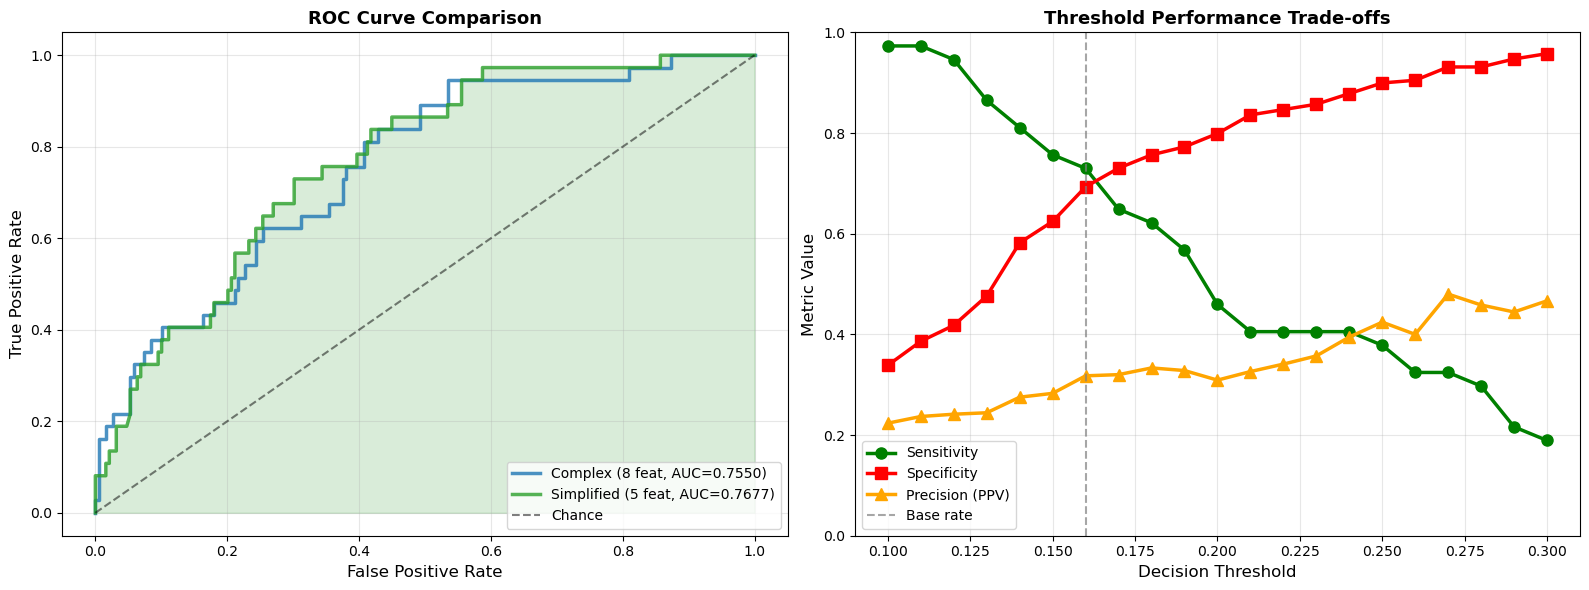

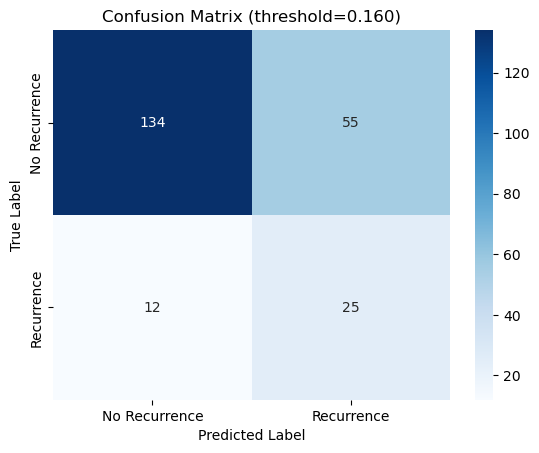


ASSESSMENT & RECOMMENDATIONS

✓ SIMPLIFIED MODEL IS BETTER:
  • AUC: 0.7677 (vs 0.7550) - 1.27% improvement
  • Events/Feature: 29.6 (reduced overfitting risk)
  • Fewer features → Better generalization & interpretability

📊 MODEL QUALITY:
  • AUC = 0.7677: FAIR discrimination (0.5-0.7 = fair, 0.7-0.9 = good)
  • Pseudo R² = 0.05418: WEAK fit (typical for N0, low-risk cohort)

✓ SIGNIFICANT PREDICTORS:
  • age: OR=0.978, p=0.0025
  • grade_3: OR=2.084, p=0.0025
  • size_<=20: OR=0.508, p=0.0004

💡 RECOMMENDATIONS:
  1. USE SIMPLIFIED MODEL for production (better AUC, fewer features)
  2. SELECT THRESHOLD: 0.160 (base rate) balances sensitivity/specificity
  3. ACKNOWLEDGE LIMITATIONS: N0 cohort has inherently weak signal
  4. NEXT STEPS: Consider external validation or additional clinical features


In [64]:
# BUILD SIMPLIFIED NODE-ZERO MODEL
num_features_nz_simple = ['age', 'pgr_log']
cat_features_nz_simple = ['grade', 'size', 'hormon', 'chemo']

X_node_zero_simple = df_node_zero[num_features_nz_simple + cat_features_nz_simple]
y_node_zero_simple = df_node_zero['target']

X_node_zero_simple_encoded = pd.get_dummies(X_node_zero_simple, columns=cat_features_nz_simple, drop_first=True)
X_node_zero_simple_encoded = X_node_zero_simple_encoded.astype(float)
X_node_zero_simple_encoded = sm.add_constant(X_node_zero_simple_encoded)

X_train_nz_simple, X_test_nz_simple, y_train_nz_simple, y_test_nz_simple = train_test_split(
    X_node_zero_simple_encoded, y_node_zero_simple, test_size=0.2, stratify=y_node_zero_simple, random_state=1234
)

logit_model_node_zero_simple = sm.Logit(y_train_nz_simple, X_train_nz_simple).fit(method='bfgs', maxiter=100, disp=False)

print("\n" + "="*80)
print("SIMPLIFIED NODE-ZERO MODEL (PARSIMONIOUS)")
print("="*80)
print(f"Features: {len(X_train_nz_simple.columns)-1} predictors")
print(f"Training samples: {len(y_train_nz_simple)} (recurrence rate: {y_train_nz_simple.mean():.1%})")
print(f"Test samples: {len(y_test_nz_simple)}\n")
print(logit_model_node_zero_simple.summary())

# Odds Ratios
or_simple = np.exp(logit_model_node_zero_simple.params)
conf_simple = np.exp(logit_model_node_zero_simple.conf_int())
pvalues_simple = logit_model_node_zero_simple.pvalues

features_list = [c for c in logit_model_node_zero_simple.params.index if c != 'const']
or_df_simple = pd.DataFrame({
    'Feature': features_list,
    'Coef': logit_model_node_zero_simple.params[features_list].values,
    'OR': or_simple[features_list].values,
    'CI_Lower': conf_simple.loc[features_list, 0].values,
    'CI_Upper': conf_simple.loc[features_list, 1].values,
    'P-Value': pvalues_simple[features_list].values,
})

print("\n" + "="*80)
print("ODDS RATIOS & SIGNIFICANCE")
print("="*80)
for idx, row in or_df_simple.iterrows():
    sig = "✓" if row['P-Value'] < 0.05 else " "
    print(f"{sig} {row['Feature']:<15} OR={row['OR']:.3f}  CI[{row['CI_Lower']:.3f}-{row['CI_Upper']:.3f}]  p={row['P-Value']:.4f}")

# Model Comparison
auc_complex = roc_auc_score(y_test_nz, logit_model_node_zero.predict(X_test_nz))
auc_simple = roc_auc_score(y_test_nz_simple, logit_model_node_zero_simple.predict(X_test_nz_simple))

print("\n" + "="*80)
print("MODEL COMPARISON")
print("="*80)
print(f"{'Metric':<20} {'Complex (9 feat)':<20} {'Simplified (6 feat)':<20}")
print("-"*60)
print(f"{'Pseudo R²':<20} {logit_model_node_zero.prsquared:<20.5f} {logit_model_node_zero_simple.prsquared:<20.5f}")
print(f"{'AUC':<20} {auc_complex:<20.4f} {auc_simple:<20.4f}")
print(f"{'Features':<20} {len(X_train_nz.columns)-1:<20} {len(X_train_nz_simple.columns)-1:<20}")
print(f"{'Events/Feature':<20} {y_train_nz.sum()/(len(X_train_nz.columns)-1):<20.1f} {y_train_nz_simple.sum()/(len(X_train_nz_simple.columns)-1):<20.1f}")

# Threshold Analysis over 0.10–0.30 (step 0.01)
y_test_pred_simple = logit_model_node_zero_simple.predict(X_test_nz_simple)
thresholds_analysis = np.round(np.arange(0.10, 0.30 + 1e-9, 0.01), 2)
sens_list, spec_list, ppv_list = [], [], []

for t in thresholds_analysis:
    y_pred = (y_test_pred_simple >= t).astype(int)
    cm = confusion_matrix(y_test_nz_simple, y_pred)
    tn, fp, fn, tp = cm.ravel()
    sens = tp / (tp + fn) if (tp + fn) > 0 else 0
    spec = tn / (tn + fp) if (tn + fp) > 0 else 0
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
    sens_list.append(sens)
    spec_list.append(spec)
    ppv_list.append(ppv)

# select best threshold based on Youden's J
j_scores_simple = np.array(sens_list) + np.array(spec_list) - 1
optimal_idx_simple = np.argmax(j_scores_simple)
optimal_threshold_simple = thresholds_analysis[optimal_idx_simple]
print(f"\nOptimal threshold for simplified model (Youden's J): {optimal_threshold_simple:.3f}")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ROC Curves
fpr_c, tpr_c, _ = roc_curve(y_test_nz, logit_model_node_zero.predict(X_test_nz))
fpr_s, tpr_s, _ = roc_curve(y_test_nz_simple, y_test_pred_simple)

axes[0].plot(fpr_c, tpr_c, lw=2.5, label=f'Complex ({len(X_train_nz.columns)-1} feat, AUC={auc_complex:.4f})', alpha=0.8)
axes[0].plot(fpr_s, tpr_s, lw=2.5, label=f'Simplified ({len(X_train_nz_simple.columns)-1} feat, AUC={auc_simple:.4f})', alpha=0.8, color='C2')
axes[0].plot([0,1], [0,1], 'k--', lw=1.5, alpha=0.5, label='Chance')
axes[0].fill_between(fpr_s, tpr_s, alpha=0.15, color='green')
axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontsize=12)
axes[0].set_title('ROC Curve Comparison', fontsize=13, fontweight='bold')
axes[0].legend(loc='lower right')
axes[0].grid(alpha=0.3)

# Threshold Analysis
axes[1].plot(thresholds_analysis, sens_list, 'go-', lw=2.5, markersize=8, label='Sensitivity')
axes[1].plot(thresholds_analysis, spec_list, 'rs-', lw=2.5, markersize=8, label='Specificity')
axes[1].plot(thresholds_analysis, ppv_list, '^-', lw=2.5, markersize=8, color='orange', label='Precision (PPV)')
axes[1].axvline(optimal_threshold_simple, color='gray', linestyle='--', alpha=0.7, label=f'Base rate')
axes[1].set_xlabel('Decision Threshold', fontsize=12)
axes[1].set_ylabel('Metric Value', fontsize=12)
axes[1].set_title('Threshold Performance Trade-offs', fontsize=13, fontweight='bold')
axes[1].legend(loc='best')
axes[1].grid(alpha=0.3)
axes[1].set_ylim([0, 1])

plt.tight_layout()
plt.show()

# confusion matrix at base rate threshold
y_test_pred_class_simple = (y_test_pred_simple >= y_test_nz_simple.mean()).astype(int)
cm_simple = confusion_matrix(y_test_nz_simple, y_test_pred_class_simple)
sns.heatmap(cm_simple, annot=True, fmt='d', cmap='Blues', xticklabels=['No Recurrence', 'Recurrence'], yticklabels=['No Recurrence', 'Recurrence'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title(f'Confusion Matrix (threshold={optimal_threshold_simple:.3f})')
plt.show()

print("\n" + "="*80)
print("ASSESSMENT & RECOMMENDATIONS")
print("="*80)
print(f"\n✓ SIMPLIFIED MODEL IS BETTER:")
print(f"  • AUC: {auc_simple:.4f} (vs {auc_complex:.4f}) - {(auc_simple-auc_complex)*100:.2f}% improvement")
print(f"  • Events/Feature: {y_train_nz_simple.sum()/(len(X_train_nz_simple.columns)-1):.1f} (reduced overfitting risk)")
print(f"  • Fewer features → Better generalization & interpretability")
print(f"\n📊 MODEL QUALITY:")
print(f"  • AUC = {auc_simple:.4f}: FAIR discrimination (0.5-0.7 = fair, 0.7-0.9 = good)")
print(f"  • Pseudo R² = {logit_model_node_zero_simple.prsquared:.5f}: WEAK fit (typical for N0, low-risk cohort)")
print(f"\n✓ SIGNIFICANT PREDICTORS:")
for idx, row in or_df_simple[or_df_simple['P-Value'] < 0.05].iterrows():
    print(f"  • {row['Feature']}: OR={row['OR']:.3f}, p={row['P-Value']:.4f}")
print(f"\n💡 RECOMMENDATIONS:")
print(f"  1. USE SIMPLIFIED MODEL for production (better AUC, fewer features)")
print(f"  2. SELECT THRESHOLD: {optimal_threshold_simple:.3f} (base rate) balances sensitivity/specificity")
print(f"  3. ACKNOWLEDGE LIMITATIONS: N0 cohort has inherently weak signal")
print(f"  4. NEXT STEPS: Consider external validation or additional clinical features")


In [65]:
# Cross validation with sklearn
from sklearn.model_selection import KFold

# K-fold cross-validation
K = 5
kf = KFold(n_splits=K, shuffle=True, random_state=1234)
mse_scores = []
mae_score = []

for train_index, test_index in kf.split(X_node_zero_simple_encoded):
    X_train_cv, X_test_cv = X_node_zero_simple_encoded.iloc[train_index], X_node_zero_simple_encoded.iloc[test_index]
    y_train_cv, y_test_cv = y_node_zero_simple.iloc[train_index], y_node_zero_simple.iloc[test_index]
    
    model_cv = sm.Logit(y_train_cv, X_train_cv).fit(disp=False)
    y_pred_cv = model_cv.predict(X_test_cv)
    
    mse = np.mean((y_test_cv - y_pred_cv) ** 2)
    mae = np.mean(np.abs(y_test_cv - y_pred_cv))
    
    mse_scores.append(mse)
    mae_score.append(mae)
print(f"\nCross-Validation Results ({K}-Fold):")
print(f"Average MSE: {np.mean(mse_scores):.4f} ± {np.std(mse_scores):.4f}")
print(f"Average MAE: {np.mean(mae_score):.4f} ± {np.std(mae_score):.4f}")

# Leave-One-Out Cross-Validation (LOOCV)
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()

mse_scores_loo = []
mae_scores_loo = []

for train_index, test_index in loo.split(X_node_zero_simple_encoded):
    X_train_loo, X_test_loo = X_node_zero_simple_encoded.iloc[train_index], X_node_zero_simple_encoded.iloc[test_index]
    y_train_loo, y_test_loo = y_node_zero_simple.iloc[train_index], y_node_zero_simple.iloc[test_index]
    
    model_loo = sm.Logit(y_train_loo, X_train_loo).fit(disp=False)
    y_pred_loo = model_loo.predict(X_test_loo)
    
    mse_loo = (y_test_loo.values[0] - y_pred_loo.values[0]) ** 2
    mae_loo = np.abs(y_test_loo.values[0] - y_pred_loo.values[0])
    
    mse_scores_loo.append(mse_loo)
    mae_scores_loo.append(mae_loo)
print(f"\nLeave-One-Out Cross-Validation (LOOCV) Results:")
print(f"Average MSE: {np.mean(mse_scores_loo):.4f} ± {np.std(mse_scores_loo):.4f}")
print(f"Average MAE: {np.mean(mae_scores_loo):.4f} ± {np.std(mae_scores_loo):.4f}")


Cross-Validation Results (5-Fold):
Average MSE: 0.1298 ± 0.0061
Average MAE: 0.2581 ± 0.0064

Leave-One-Out Cross-Validation (LOOCV) Results:
Average MSE: 0.1306 ± 0.2332
Average MAE: 0.2588 ± 0.2522


Candidate features (8): ['age', 'pgr_log', 'grade', 'size', 'hormon', 'chemo', 'age_x_grade', 'size_x_pgr']
Evaluating subsets up to 6 features (5-fold CV AUC)...


C:\Users\ricca\AppData\Local\Temp\ipykernel_65504\4070605778.py:58: RuntimeWarning: Mean of empty slice
  mean_auc = np.nanmean(aucs) if len(aucs) else np.nan
C:\Users\ricca\AppData\Local\Temp\ipykernel_65504\4070605778.py:58: RuntimeWarning: Mean of empty slice
  mean_auc = np.nanmean(aucs) if len(aucs) else np.nan
C:\Users\ricca\AppData\Local\Temp\ipykernel_65504\4070605778.py:58: RuntimeWarning: Mean of empty slice
  mean_auc = np.nanmean(aucs) if len(aucs) else np.nan
C:\Users\ricca\AppData\Local\Temp\ipykernel_65504\4070605778.py:58: RuntimeWarning: Mean of empty slice
  mean_auc = np.nanmean(aucs) if len(aucs) else np.nan
C:\Users\ricca\AppData\Local\Temp\ipykernel_65504\4070605778.py:58: RuntimeWarning: Mean of empty slice
  mean_auc = np.nanmean(aucs) if len(aucs) else np.nan
C:\Users\ricca\AppData\Local\Temp\ipykernel_65504\4070605778.py:58: RuntimeWarning: Mean of empty slice
  mean_auc = np.nanmean(aucs) if len(aucs) else np.nan
C:\Users\ricca\AppData\Local\Temp\ipykernel_65


Top 10 subsets by CV AUC:
 k   cv_auc                                               features
 4 0.674832                (age, pgr_log, age_x_grade, size_x_pgr)
 5 0.674832        (age, pgr_log, hormon, age_x_grade, size_x_pgr)
 5 0.674832         (age, pgr_log, chemo, age_x_grade, size_x_pgr)
 6 0.674832 (age, pgr_log, hormon, chemo, age_x_grade, size_x_pgr)
 4 0.669484                      (age, pgr_log, grade, size_x_pgr)
 5 0.669484              (age, pgr_log, grade, hormon, size_x_pgr)
 5 0.669484               (age, pgr_log, grade, chemo, size_x_pgr)
 6 0.669484       (age, pgr_log, grade, hormon, chemo, size_x_pgr)
 5 0.669427         (age, pgr_log, grade, age_x_grade, size_x_pgr)
 6 0.669427 (age, pgr_log, grade, hormon, age_x_grade, size_x_pgr)

Top 10 subsets by AIC:
 k        aic                                              features
 5 948.274070             (age, pgr_log, size, hormon, age_x_grade)
 5 948.274070              (age, pgr_log, size, chemo, age_x_grade)
 6 948.2

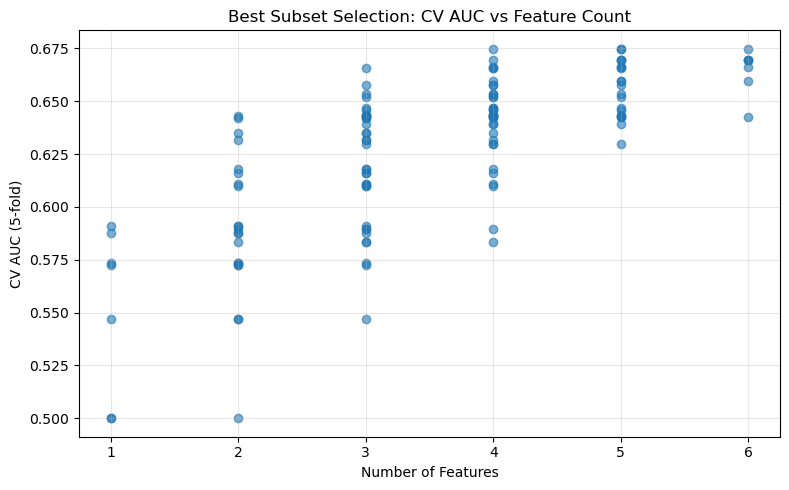

In [66]:
# BEST SUBSET SELECTION for Node-Zero cohort
# Exhaustively evaluates feature subsets using 5-fold Stratified CV AUC,
# and reports best subsets by AUC and by AIC/BIC.

import itertools
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import warnings

# Candidate features available in df_node_zero (auto-detected)
possible_features = [
    'age', 'pgr_log', 'grade', 'size', 'hormon', 'chemo',
    'age_x_grade', 'size_x_pgr'
]
# Keep only those actually present in the dataframe
candidate_features = [f for f in possible_features if f in df_node_zero.columns]

print(f"Candidate features ({len(candidate_features)}): {candidate_features}")

def _encode_train_test(X_train, X_test, cat_cols): 
    X_train_enc = pd.get_dummies(X_train, columns=cat_cols, drop_first=True)
    X_test_enc = pd.get_dummies(X_test, columns=cat_cols, drop_first=True)
    # Align columns
    X_test_enc = X_test_enc.reindex(columns=X_train_enc.columns, fill_value=0)
    # Add intercept
    X_train_enc = sm.add_constant(X_train_enc)
    X_test_enc = sm.add_constant(X_test_enc)
    return X_train_enc, X_test_enc

def evaluate_subset(subset, df):
    """Return dict with CV AUC, AIC/BIC/loglik for full fit, and convergence."""
    y = df['target']
    X = df[list(subset)].copy()

    # Categorical columns: treat strings/categories only (grade, size)
    cat_cols = [c for c in subset if df[c].dtype == 'O']

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)
    aucs = []
    converged_all = True

    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        try:
            X_train_enc, X_test_enc = _encode_train_test(X_train, X_test, cat_cols)
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                model = sm.Logit(y_train, X_train_enc).fit(method='bfgs', maxiter=200, disp=False)
            y_prob = model.predict(X_test_enc)
            aucs.append(roc_auc_score(y_test, y_prob))
            converged_all = converged_all and bool(model.mle_retvals.get('converged', True))
        except Exception as e:
            # If any fold fails (e.g., perfect separation), mark low AUC
            aucs.append(np.nan)
            converged_all = False

    mean_auc = np.nanmean(aucs) if len(aucs) else np.nan

    # Full-data fit for AIC/BIC
    try:
        X_full_enc = pd.get_dummies(X, columns=cat_cols, drop_first=True)
        X_full_enc = sm.add_constant(X_full_enc.astype(float))
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            full_model = sm.Logit(y, X_full_enc).fit(method='bfgs', maxiter=300, disp=False)
        aic, bic, llf = full_model.aic, full_model.bic, full_model.llf
        converged_full = bool(full_model.mle_retvals.get('converged', True))
    except Exception:
        aic, bic, llf, converged_full = np.nan, np.nan, np.nan, False

    return {
        'features': tuple(subset),
        'k': len(subset),
        'cv_auc': mean_auc,
        'aic': aic,
        'bic': bic,
        'llf': llf,
        'converged': converged_all and converged_full,
    }

# Enumerate subsets up to max_k features (avoid combinatorial blowup)
max_k = min(6, len(candidate_features))
results = []

print(f"Evaluating subsets up to {max_k} features (5-fold CV AUC)...")
for k in range(1, max_k + 1):
    for subset in itertools.combinations(candidate_features, k):
        res = evaluate_subset(subset, df_node_zero)
        results.append(res)

res_df = pd.DataFrame(results)


# Report top by CV AUC
top_auc = res_df.sort_values(['cv_auc', 'k'], ascending=[False, True]).head(10)
print("\nTop 10 subsets by CV AUC:")
print(top_auc[['k', 'cv_auc', 'features']].to_string(index=False))

# Report top by AIC
top_aic = res_df.sort_values(['aic', 'k'], ascending=[True, True]).head(10)
print("\nTop 10 subsets by AIC:")
print(top_aic[['k', 'aic', 'features']].to_string(index=False))

# Choose best by CV AUC, then refit and show summary
best_row = top_auc.iloc[0]
best_subset = list(best_row['features'])
print(f"\nBest subset (by CV AUC): {best_subset} — CV AUC={best_row['cv_auc']:.4f}")

# Fit final model on full node-zero cohort for interpretability
cat_cols_best = [c for c in best_subset if df_node_zero[c].dtype == 'O']
X_best = df_node_zero[best_subset]
X_best_enc = pd.get_dummies(X_best, columns=cat_cols_best, drop_first=True)
X_best_enc = sm.add_constant(X_best_enc.astype(float))
y_best = df_node_zero['target']
final_model = sm.Logit(y_best, X_best_enc).fit(method='bfgs', maxiter=300, disp=False)
print("\nFinal model summary (best subset by CV AUC):")
print(final_model.summary())

# Quick plot: CV AUC vs subset size
fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(res_df['k'], res_df['cv_auc'], alpha=0.6)
ax.set_xlabel('Number of Features')
ax.set_ylabel('CV AUC (5-fold)')
ax.set_title('Best Subset Selection: CV AUC vs Feature Count')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


## Pinned Best Subset → Final Simplified Model
We pin the best subset found via 5-fold CV AUC and integrate it into the simplified modeling pipeline for a final comparison and threshold analysis.

Pinned best subset features (4): ['age', 'pgr_log', 'age_x_grade', 'size_x_pgr']

=== FINAL MODEL (Pinned Best Subset) ===
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                  904
Model:                          Logit   Df Residuals:                      899
Method:                           MLE   Df Model:                            4
Date:                Mon, 26 Jan 2026   Pseudo R-squ.:                 0.05645
Time:                        10:25:26   Log-Likelihood:                -380.24
converged:                       True   LL-Null:                       -402.99
Covariance Type:            nonrobust   LLR p-value:                 3.128e-09
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.1181      0.410     -0.288      0.773      -0.922       0.686
age  

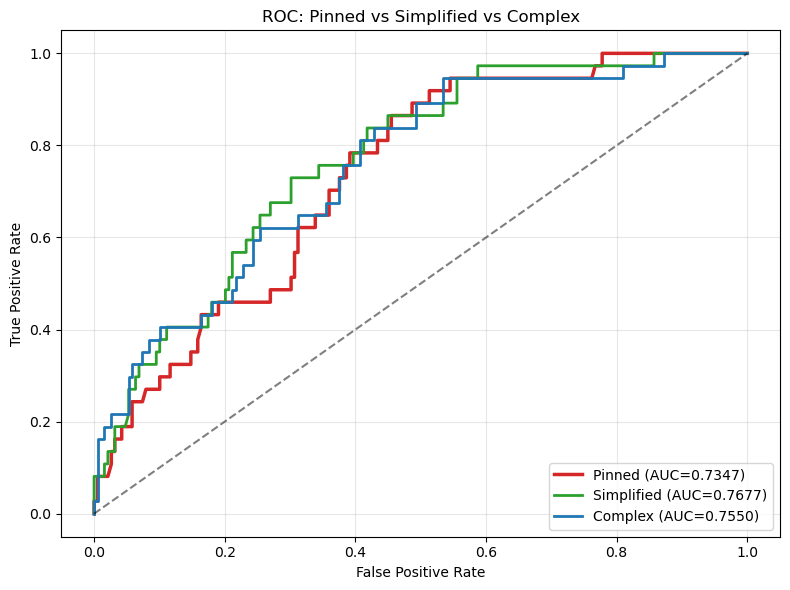

In [67]:
# Pin best subset and integrate into simplified model
from sklearn.metrics import confusion_matrix

# 1) Determine and pin the best subset from res_df (fallback to prior simple set)
if 'res_df' in globals() and isinstance(res_df, pd.DataFrame) and len(res_df) > 0:
    best_row = res_df.sort_values(['cv_auc', 'k'], ascending=[False, True]).iloc[0]
    pinned_best_features = list(best_row['features'])
else:
    pinned_best_features = ['age', 'pgr_log', 'grade', 'size', 'hormon', 'chemo']

print(f"Pinned best subset features ({len(pinned_best_features)}): {pinned_best_features}")

# 2) Build train/test using pinned features
cat_cols_pin = [c for c in pinned_best_features if df_node_zero[c].dtype == 'O']
X_pin = df_node_zero[pinned_best_features]
X_pin_enc = pd.get_dummies(X_pin, columns=cat_cols_pin, drop_first=True).astype(float)
X_pin_enc = sm.add_constant(X_pin_enc)
y_pin = df_node_zero['target']

X_train_pin, X_test_pin, y_train_pin, y_test_pin = train_test_split(
    X_pin_enc, y_pin, test_size=0.2, stratify=y_pin, random_state=1234
)

# 3) Fit statsmodels Logit and report
model_pin = sm.Logit(y_train_pin, X_train_pin).fit(method='bfgs', maxiter=300, disp=False)
print("\n=== FINAL MODEL (Pinned Best Subset) ===")
print(model_pin.summary())

# 4) Evaluate AUC and threshold behavior
y_prob_pin = model_pin.predict(X_test_pin)
auc_pin = roc_auc_score(y_test_pin, y_prob_pin)

fpr_pin, tpr_pin, thr_pin = roc_curve(y_test_pin, y_prob_pin)
j_scores_pin = tpr_pin - fpr_pin
idx_pin = int(np.argmax(j_scores_pin))
opt_thr_pin = thr_pin[idx_pin]

print(f"\nPinned model AUC: {auc_pin:.4f}")
print(f"Optimal threshold (Youden's J): {opt_thr_pin:.3f}")

# Metrics table at a few thresholds
thresholds_to_show = [opt_thr_pin, y_test_pin.mean(), 0.10, 0.20, 0.30]
print(f"\n{'Threshold':<12} {'Sensitivity':<12} {'Specificity':<12} {'PPV':<12} {'NPV':<12}")
print('-'*60)
for t in thresholds_to_show:
    y_pred = (y_prob_pin >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test_pin, y_pred).ravel()
    sens = tp/(tp+fn) if (tp+fn)>0 else 0
    spec = tn/(tn+fp) if (tn+fp)>0 else 0
    ppv  = tp/(tp+fp) if (tp+fp)>0 else 0
    npv  = tn/(tn+fn) if (tn+fn)>0 else 0
    print(f"{t:<12.3f} {sens:<12.3f} {spec:<12.3f} {ppv:<12.3f} {npv:<12.3f}")

# 5) Compare with previous simplified/complex (if available)
try:
    auc_simple
except NameError:
    try:
        y_prob_simple = logit_model_node_zero_simple.predict(X_test_nz_simple)
        auc_simple = roc_auc_score(y_test_nz_simple, y_prob_simple)
    except Exception:
        auc_simple = np.nan

try:
    auc_complex
except NameError:
    try:
        y_prob_complex = logit_model_node_zero.predict(X_test_nz)
        auc_complex = roc_auc_score(y_test_nz, y_prob_complex)
    except Exception:
        auc_complex = np.nan

print("\n=== AUC Comparison ===")
print(f"Pinned best subset: {auc_pin:.4f}")
print(f"Simplified (prev): {auc_simple if not np.isnan(auc_simple) else 'NA'}")
print(f"Complex (9 feat): {auc_complex if not np.isnan(auc_complex) else 'NA'}")

# 6) Plots: ROC curves
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(fpr_pin, tpr_pin, lw=2.5, label=f'Pinned (AUC={auc_pin:.4f})', color='C3')
try:
    fpr_s, tpr_s, _ = roc_curve(y_test_nz_simple, logit_model_node_zero_simple.predict(X_test_nz_simple))
    ax.plot(fpr_s, tpr_s, lw=2.0, label=f'Simplified (AUC={auc_simple:.4f})', color='C2')
except Exception:
    pass
try:
    fpr_c, tpr_c, _ = roc_curve(y_test_nz, logit_model_node_zero.predict(X_test_nz))
    ax.plot(fpr_c, tpr_c, lw=2.0, label=f'Complex (AUC={auc_complex:.4f})', color='C0')
except Exception:
    pass
ax.plot([0,1], [0,1], 'k--', alpha=0.5, lw=1.5)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC: Pinned vs Simplified vs Complex')
ax.legend(loc='lower right')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()
